In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import fill_grid, assign_id, calc_nodes_samples


# Read data and clean

In [2]:
# read data
df = pd.read_csv("../data/df_raw.csv")
## subset relevant columns
df = df[["q", "q_id", "answers", "answer_val", "related_parent_q", "entry_name", "entry_id", "end_year"]]
## only overall questions (without parent)
df = df[df["related_parent_q"].isna()]
## assign new id (because their id is not unique)
#df = assign_id(df, "q", "q_id")
## if more than one answer to a question sample 1. 
df = df.sample(frac = 1.0).groupby(['q_id', 'entry_id']).head(1)


/home/vpoulsen/religion-glass/relenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Remove Q with non-binary answers (18/287 Q)

In [3]:
# remove questions with non-binary answers
## code answer types
conditions = [
    (df['answers'] == "Yes") | (df["answers"] == "No"),
    (df['answers'] == "Field doesn't know") | (df["answers"] == "I don't know"),
    (df['answers'] == "NaN")
]
choices = ["Yes/No", "Don't know", "NaN"]
df['answer_types'] = np.select(conditions, choices, default="non-binary")

## find questions with non-binary answers and remove them
df_ = df.groupby(['q_id', 'answer_types']).size().reset_index(name="count")
df_ = df_[df_["answer_types"] == "non-binary"]
df_ = df.merge(df_, how = "outer", indicator = True)
df_b = df_[(df_._merge=="left_only")].drop("_merge", axis = 1)

## how many questions did we exclude?
q_total = len(df["q_id"].drop_duplicates())
q_binary = len(df_b["q_id"].drop_duplicates()) 
print(f"total Q: {q_total}\nbinary Q: {q_binary} ({round(q_binary/q_total,2)})%")


total Q: 596
binary Q: 548 (0.92)%


# All combinations of Q (node) and CIV (sample)

In [4]:
# create nodes X samples X NA
## fill unanswered questions with NaN
df_nan = fill_grid(df_b, "q_id", "entry_id", "NaN")
n_samples = len(df_nan["entry_id"].drop_duplicates())
n_nodes = len(df_nan["q_id"].drop_duplicates())
print(f"number of civilizations (samples): {n_samples}")
print(f"number of questions (nodes): {n_nodes}")


number of civilizations (samples): 836
number of questions (nodes): 548


# Run calculation for plot below

In [5]:
## nodes X samples = NA
d_lineplot = calc_nodes_samples(
    d = df_nan,
    min_col = "NaN",
    node_lst = [x+1 for x in range(n_nodes)],
    sample_lst = [100, 200, 300, 400, 500, 600, 700, n_samples]
)

## convert to factor
d_lineplot["n_samples"] = d_lineplot["n_samples"].astype('category')

# Plot NaN for questions x civilizations

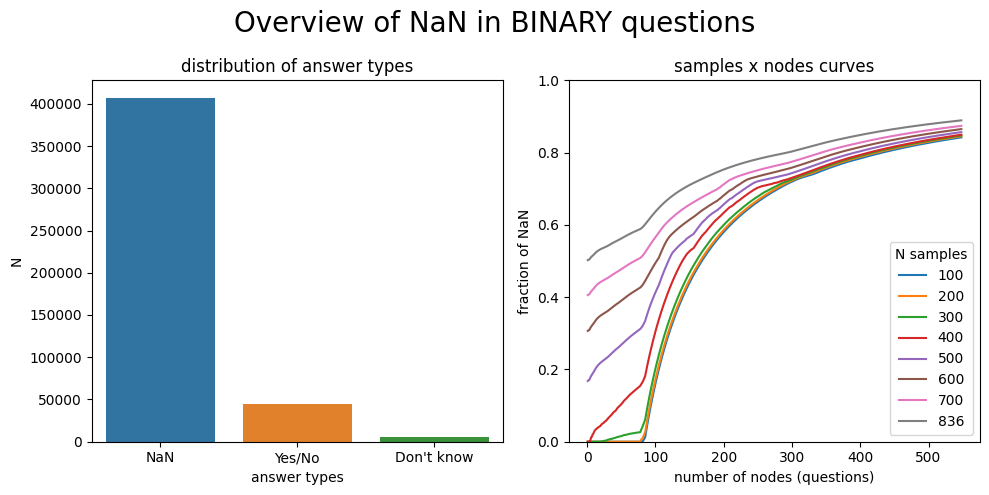

In [10]:
## plot
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sns.countplot(
    ax = axes[0],
    data = df_nan,
    x = "answer_types",
    order = df_nan["answer_types"].value_counts().index
)
axes[0].set(
    xlabel = "answer types",
    ylabel = "N",
    title = "distribution of answer types"
)
sns.lineplot(
    ax = axes[1],
    data = d_lineplot,
    x = "n_nodes", 
    y = "frac_na",
    hue = "n_samples",
)
axes[1].set(
    xlabel = "number of nodes (questions)",
    ylabel = "fraction of NaN",
    title = "samples x nodes curves",
    ylim = (0, 1),
)
axes[1].legend(title = "N samples")
plt.suptitle("Overview of NaN in BINARY questions", fontsize = 20)
plt.tight_layout()
plt.show();

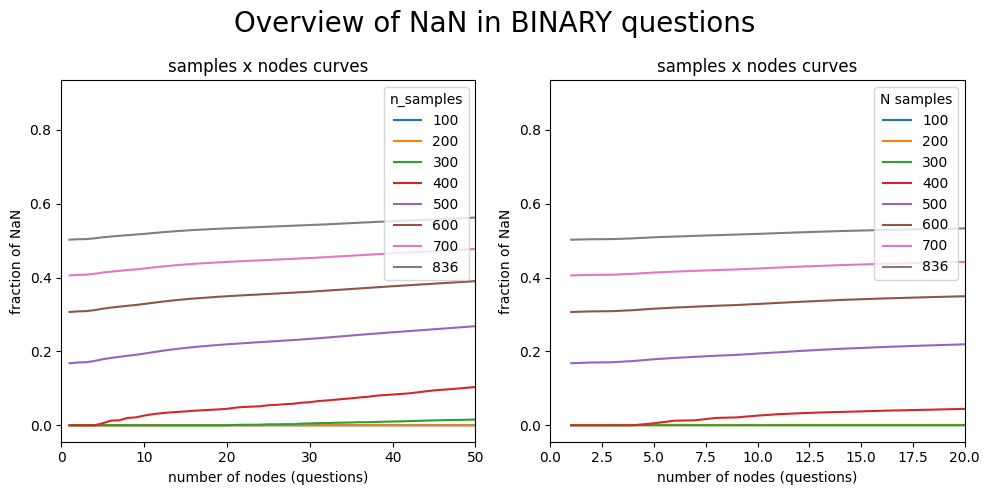

In [11]:
## plot
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.lineplot(
    ax = axes[0],
    data = d_lineplot,
    x = "n_nodes", 
    y = "frac_na",
    hue = "n_samples",
)
axes[0].set(
    xlabel = "number of nodes (questions)",
    ylabel = "fraction of NaN",
    title = "samples x nodes curves",
    xlim = (0, 50)
)
sns.lineplot(
    ax = axes[1],
    data = d_lineplot,
    x = "n_nodes", 
    y = "frac_na",
    hue = "n_samples",
)
axes[1].set(
    xlabel = "number of nodes (questions)",
    ylabel = "fraction of NaN",
    title = "samples x nodes curves",
    xlim = (0, 20)
)
axes[1].legend(title = "N samples")
plt.suptitle("Overview of NaN in BINARY questions", fontsize = 20)
plt.tight_layout()
plt.show();

NB: actually this is even worse that it looks, because we are only plotting fraction of NaN here, but we also have "Field doesn't know" and "I don't know", so the fraction of answers that is not either "Yes" or "No" is worse than what is indicated here. 

# Investigate patterns over time (e.g. more missing data for old religions?)

In [7]:
# Missing data over time 
## over time across questions 
df_e_a = df_nan.groupby(["entry_id", "answer_types"]).size().reset_index(name = "count")
df_e_a = pd.pivot(df_e_a, index = "entry_id", columns = "answer_types", values = "count").fillna(0)
df_e_y = df_nan[df_nan["end_year"] != "NaN"][["end_year", "entry_id"]].drop_duplicates()
df_e_y = df_e_y.sample(frac = 1.0).groupby(["entry_id"]).head(1) # not unique year per entry...?!
df_t = df_e_a.merge(df_e_y, on = "entry_id", how = "inner")

## completeness of data over time (grouped by cardinality)
df_t["q_cut"] = pd.qcut(df_t["end_year"], q = 10)
df_t = df_t.sort_values('q_cut', ascending=True)

# fractions (not the most pretty)
df_t["frac_nan"] = df_t["NaN"] / n_nodes
df_t["frac_yn"] = df_t["Yes/No"] / n_nodes
df_t["frac_dk"] = df_t["Don't know"] / n_nodes

# we need new index 
df_i = df_t[["q_cut"]].drop_duplicates()
df_i["index"] = range(10)
df_t = df_t.merge(df_i, on = "q_cut", how = "inner")

# only fractions and long 
df_t_f = df_t[[
    "q_cut", 
    "index", 
    "entry_id", 
    "frac_nan", 
    "frac_yn", 
    "frac_dk"]]

df_t_f_l = pd.wide_to_long(
    df_t_f,
    stubnames = "frac",
    i = "entry_id",
    j = "answer",
    sep = "_",
    suffix = r"\w+"
).reset_index()

# prepare plot 
len_id = len(df_t_f_l[["q_cut"]].drop_duplicates())
x = df_t_f_l["q_cut"].unique().to_list()
df_t_f_l["answer"] = df_t_f_l["answer"].replace(
    ["nan", "dk", "yn"], 
    ["NaN", "Don't know", "Yes/No"])

## Plot it 

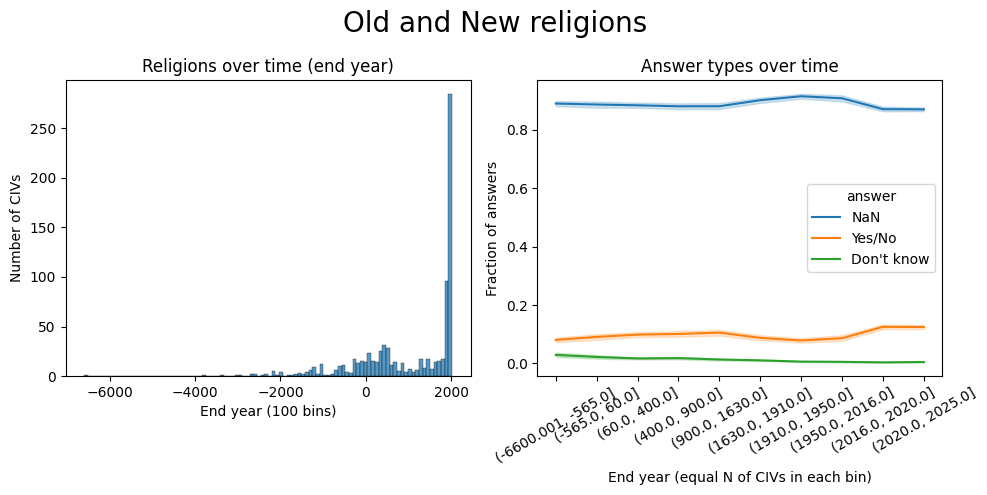

In [8]:

# plot it 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(
    ax = axes[0],
    x = "end_year",
    data = df_t,
    bins = 100
)
axes[0].set(
    xlabel = "End year (100 bins)",
    ylabel = "Number of CIVs",
    title = "Religions over time (end year)"
)

sns.lineplot(
    ax = axes[1],
    data = df_t_f_l,
    x = "index",
    y = "frac",
    hue = "answer"
)
axes[1].set(
    xlabel = "End year (equal N of CIVs in each bin)",
    ylabel = "Fraction of answers",
    title = "Answer types over time"
)
axes[1].set_xticks(range(len_id), x)
axes[1].set_xticklabels(x, rotation = 30)
plt.suptitle("Old and New religions", fontsize = 20)
plt.tight_layout()
plt.show();